# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
Y = pd.read_csv('exons_counts.csv',index_col=[0])
X = pd.read_csv('time_points.csv',index_col=[0])
#X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
X

,time
E11_1_F,95.0
E12_1_F,105.0
E13A_1_F,115.0
E13B_1_F,125.0
E14A_1_F,145.0
E14B_1_F,160.0
E14C_1_F,175.0
E14D_1_F,190.0
E14E_1_F,205.0
ECF_1_F,220.0


Fit some fission gene normalized data using GPcounts -- Two samples test

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [19]:
genes_name = [
 'FBgn0028670',
'FBgn0031449']
 

In [15]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
results = gp_counts.One_sample_test(likelihood)
results['likelihood']

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0028670,-159.394212,-3222.709594,3063.315383
FBgn0250820,-132.526670,-131.923396,-0.603274


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


FBgn0028670


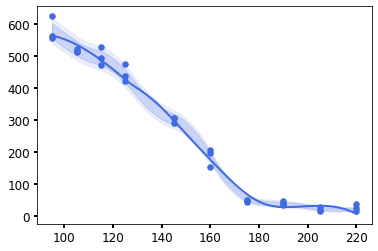

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,16.938805733387674
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,22.049471513457796
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,3.517183593579729e-08
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.54661795e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.81414408e-03, 0.00000000e+00, 0.00000000e+00..."


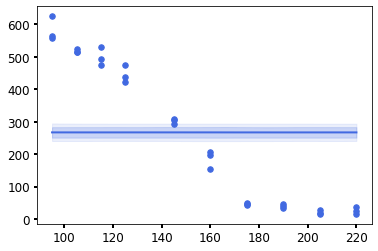

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,18.748204655736632
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,3.517183593579729e-08
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.29022368e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.59189428e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0250820


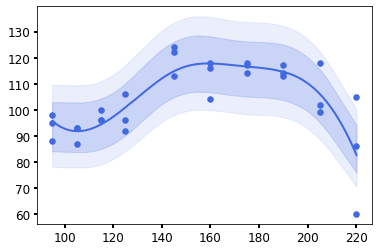

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,10.567861493203383
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,38.26889871370639
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,7.209788321913167e-13
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.39230495e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.69243768e-02, 0.00000000e+00, 0.00000000e+00..."


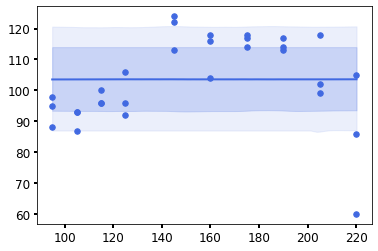

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,18.72469698292034
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,7.209788321913167e-13
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.07175844e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[4.15072948e-03, 0.00000000e+00, 0.00000000e+00..."


In [16]:
indexes = genes_name # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [17]:
likelihood = 'Gaussian'
results = gp_counts.One_sample_test(likelihood)
results['likelihood']

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0028670,-11.853839,-53.484646,41.630807
FBgn0250820,15.168174,9.797433,5.370741


100%|██████████| 2/2 [00:00<00:00, 25.59it/s]


FBgn0028670


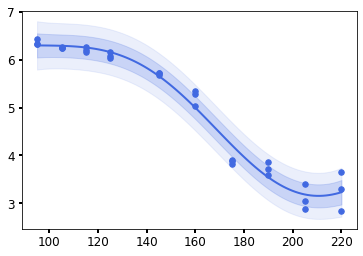

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,20.134
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,62.6317
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0502443


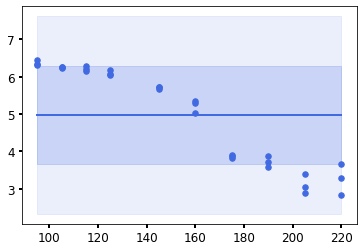

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,24.7861
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.69011


FBgn0250820


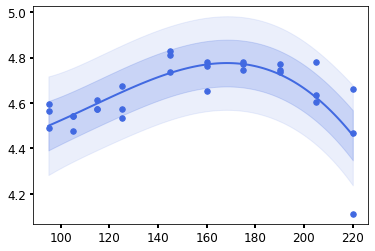

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.4914
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,148.484
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00977441


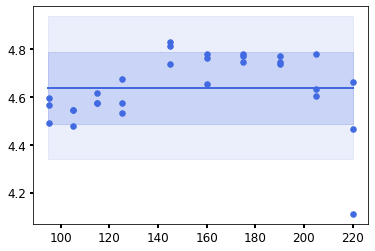

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.5087
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0216119


In [18]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')